In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# External dependencies
import numpy as np
import matplotlib.pyplot as plt

# Internal dependencies
from srvpy.open import HJBSolverC
from srvpy.open import samplepaths as sp

# Basic Usage

This is a demonstration on computing shape space geodesics using the srvpy package. 

We start by loading the curves. In this example, we point data representing chess pieces knight and bishop. The curves takes values in the complex plane, meaning that the curves `c1` and `c2` are complex `ndarrays`. 

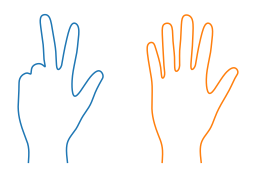

In [2]:
# Construct path using svgpathtools and compute their lengths
n = 500
t = np.linspace(0,1,n+1)
c1 = sp.Hand3()
c2 = sp.Hand5()

# Plot the shapes
plt.figure(figsize=(10,3))
plt.plot(c1(t).real,c1(t).imag)
plt.plot(c2(t).real+25,c2(t).imag)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

### The HJBSolver

The `HJBSolver` object is the object used to register curves and compute shape space geodesics. There are two versions of the solver, `HJBSolverC` and `HJBSolverQ`. 

- `HJBSolverC` takes callables representing two curves `c1` and `c2` and estimates their SRV transforms. This solver is therefore limited to registering curves using the SRV framework.
- `HJBSolverQ` takes callables representing two Q-transformed curves `q1` and `q2`. The Q-transform can be the SRV transform but can also be other options.

The initialization of the objects looks like `HJBSolverC(c1, c2, x1, x2=None, scheme=VInf, unit_sphere=False, normalize=False)`. 

- `c1` and `c2` are the callable curves. The callables takes ndarray (n,) objects as input and outputs either ndarray (n,) or ndarray (n,d). 
- `x1` and `x2` are either the grids, or the number of grid cells to be used in each dimension. If `x2` is not specified, we set `x1=x2`.
- `scheme` is the scheme used by the solver. The `scheme` object must include the methods `.solve(solver,i,j)` and `alpha(solver,i,j)`. 
- `unit_sphere` specifies whether the unit sphere or L2 topology should be used to compute distances and geodesics.
- `normalize` specified whether the curves should be normalized to be approximately unit length.

In [3]:
solver = HJBSolverC(c1,c2,n,unit_sphere=True,normalize=True)

### Distance Estimation

The solver object can be used to compute distances between the curves. This is done using the `.distance()` object which computes distance of the piecewise linear path with nodes at (`x1[i]`,`x2[i]`). In order for this method to work, the grids must be of same dimension.

In [4]:
dist = solver.distance()
print('Pre-shape space distance before registration: {:.3f}'.format(dist))

Pre-shape space distance before registration: 1.241


### Computation of geodesic.

We can compute geodesics using the `.geodesic(tau,length='invariant')` object. `tau` specifies at which times the geodesic should be evaluated. `length` specifies how the lengths of the curves should be interpolated:

- `invariant` gives unit length geodesics.
- `linear` gives geodesics with linearly changing length $l(\tau) = (1-\tau)L_1 + \tau L_2$.
- `logarithmic` gives geodesics where the length vary as $l(\tau) = \exp((1-\tau)\log L_1 + \tau \log L_2)$.

Since the curves are not yet optimally reparametrized, the pre-shape geodesics will not be optimal.

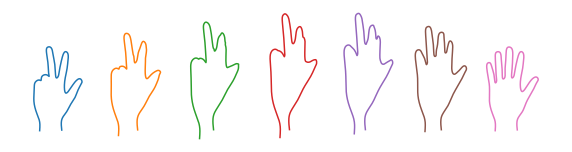

In [5]:
# Compute the pre-shape space geodesic
tau = np.linspace(0,1,7)
gamma = solver.geodesic(tau,length='logarithmic')

# Plot the geodesic
plt.figure(figsize=(10,3))
for i in range(7):
    plt.plot(gamma[i,:].real+25*i,gamma[i,:].imag)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

### Registering the Curves

Registration of the curves is performed using the `HJBSolver.register()` method. This method has three steps:

- `HJBSolver.solve_hjb(self)` solves the HJB equation.
- `phi = HJBSolver.backtrack_hjb(self)` backtracks the HJB equation to obtain an estimate `phi` to the optimal reparametrization path.
- `HJBSolver.resample(self,phi)` resamples the curves stored in the `HJBSolver` object such that each point in `HJBSolver.c1` and `HJBSolver.c2` are registered to each other.

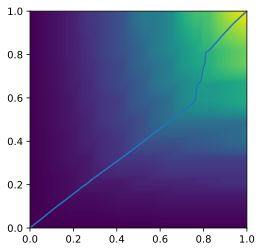

In [6]:
# Solve and backtrack the HJB equation
solver.solve_hjb()
phi = solver.backtrack_hjb()

# Plot the value function and the optimal path
plt.imshow(solver.value.T, extent=(0,1,0,1), origin='lower')
plt.plot(phi[:,0], phi[:,1])
plt.show()

# Resample the curves
solver.resample(phi[:,0], phi[:,1])

We can now compute the proper shape space distance and shape space geodesic.

Shape space distance: 0.379


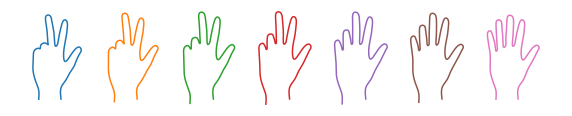

In [8]:
# Print the shapce space distance
dist = solver.distance()
print('Shape space distance: {:.3f}'.format(dist))

# Compute the shape space geodesic
tau = np.linspace(0,1,7)
gamma = solver.geodesic(tau,length='logarithmic')

# Plot the geodesic
plt.figure(figsize=(10,3))
for i in range(7):
    plt.plot(gamma[i,:].real+25*i,gamma[i,:].imag)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()